In [2]:
import re
import itertools
import numpy as np
import pandas as pd
import skfuzzy as fuzz
import skfuzzy.control as ctrl
import matplotlib.pyplot as plt
from tabulate import tabulate

## Fuzzificação

C:\Users\yvesa\miniconda3\envs\fuzzy\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


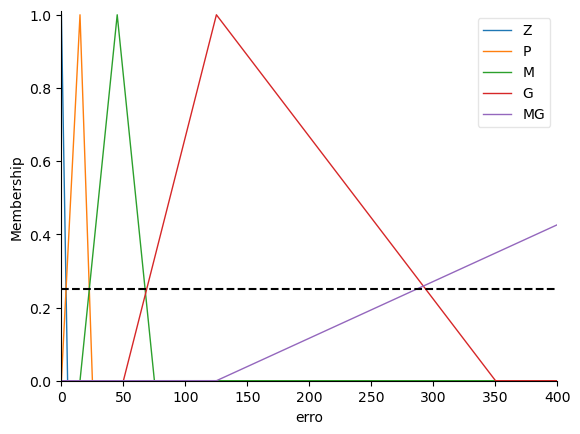

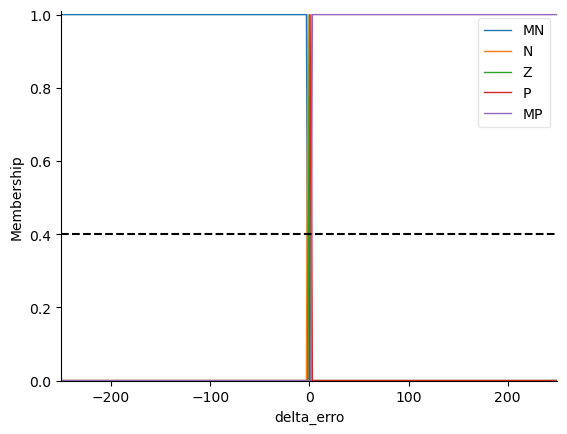

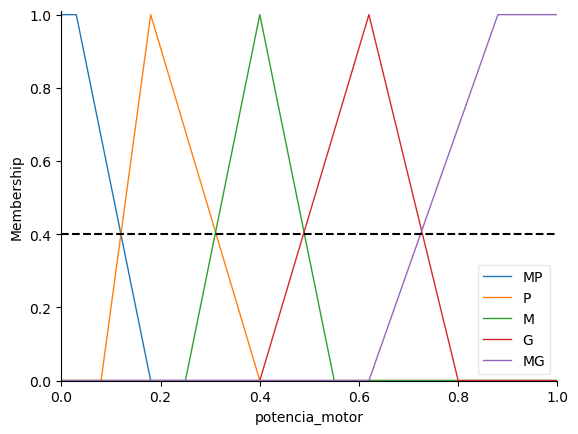

In [3]:
# Definindo os universos para as variáveis de entrada e saída
erro = ctrl.Antecedent(np.arange(0, 1000.1, 0.1), 'erro')
delta_erro = ctrl.Antecedent(np.arange(-1000, 1000.5, 0.5), 'delta_erro')
potencia_motor = ctrl.Consequent(np.arange(0, 1.01, 0.01), 'potencia_motor')


# Definindo funções de pertinência para o erro
erro['Z'] = fuzz.trimf(erro.universe, [0, 0, 5])
erro['P'] = fuzz.trimf(erro.universe, [0, 15, 25])
erro['M'] = fuzz.trimf(erro.universe, [15, 45, 75])
erro['G'] = fuzz.trimf(erro.universe, [50, 125, 350])
erro['MG'] = fuzz.trimf(erro.universe, [125, 770, 1000]) # muito longe + descendo muito, - contrario

# Definindo funções de pertinência para delta_erro
delta_erro['MN'] = fuzz.trapmf(delta_erro.universe, [-1000, -1000, -3, -1.5])
delta_erro['N'] = fuzz.trimf(delta_erro.universe, [-3, -1.5, 0])
delta_erro['Z'] = fuzz.trimf(delta_erro.universe, [-1.5, 0, 1.5])
delta_erro['P'] = fuzz.trimf(delta_erro.universe, [0, 1.5, 3])
delta_erro['MP'] = fuzz.trapmf(delta_erro.universe, [1.5, 3, 1000, 1000])


# Definindo funções de pertinência para potencia_motor_direto e potencia_motor_reverso
potencia_motor['MP'] = fuzz.trapmf(potencia_motor.universe, [0, 0, 0.03,0.18])
potencia_motor['P'] = fuzz.trimf(potencia_motor.universe, [0.08, 0.18, 0.4])
potencia_motor['M'] = fuzz.trimf(potencia_motor.universe, [0.25, 0.4, 0.55])
potencia_motor['G'] = fuzz.trimf(potencia_motor.universe, [0.4, 0.62, 0.8])
potencia_motor['MG'] = fuzz.trapmf(potencia_motor.universe, [0.62, 0.88, 1, 1])

erro.view()
plt.axline((0, 0.25), (1000, 0.25), color='black', linestyle='--')
plt.xlim(0, 400)

delta_erro.view()
plt.axline((0, 0.4), (1000, 0.4), color='black', linestyle='--')
plt.xlim(-250, 250)

potencia_motor.view()
plt.axline((0, 0.4), (1000, 0.4), color='black', linestyle='--')


## Base de Regras

In [4]:
# Criação das regras para o controle

result_potencia = [
    'MP', 'P' , 'M' , 'G' , 'MG' ,
    'MP', 'P' , 'M' , 'M' , 'M' ,
    'P' , 'P' , 'M' , 'M' , 'G' ,
    'P' , 'M' , 'M' , 'G' , 'G' ,
    'M' , 'M' , 'G' , 'G' , 'MG' ,
]

BaseRegras = [
    ctrl.Rule(erro[Erro] & delta_erro[Delta_erro], potencia_motor[Potencia_motor])
    for (Erro, Delta_erro), Potencia_motor in
    zip(itertools.product(erro.terms.keys(), delta_erro.terms.keys()), result_potencia)
]

In [5]:
ciano = '\033[96m'  # Define a cor azul-ciano

tabela = []
for Erro in erro.terms:
  for Delta_erro in delta_erro.terms:
    for regra in BaseRegras:
      antecedente = str(regra).split('IF ')[1].split(' THEN')[0].replace('AND ', '')
      consequente = str(regra).split('IF ')[1].split(' THEN')[1].split('AND ')[0]

      classificacoes = re.findall(r'\[(.*?)\]', (antecedente + consequente))
      if Erro == classificacoes[0] and Delta_erro == classificacoes[1]:
        tabela.append([classificacoes[0], classificacoes[1], classificacoes[2]])
        break

df = pd.DataFrame(tabela, columns=[erro.label, delta_erro.label, potencia_motor.label])
pivotTable = pd.DataFrame(df.pivot(index=delta_erro.label, columns=erro.label, values=potencia_motor.label).reindex(index=delta_erro.terms, columns=erro.terms))
pivotTable.index.name = f'{ciano}{"E"}\033[0m'
print(tabulate(pivotTable, headers='keys', tablefmt='fancy_grid', stralign='center', showindex='always'))

╒═════╤═════╤═════╤═════╤═════╤══════╕
│  E  │  Z  │  P  │  M  │  G  │  MG  │
╞═════╪═════╪═════╪═════╪═════╪══════╡
│ MN  │ MP  │ MP  │  P  │  P  │  M   │
├─────┼─────┼─────┼─────┼─────┼──────┤
│  N  │  P  │  P  │  P  │  M  │  M   │
├─────┼─────┼─────┼─────┼─────┼──────┤
│  Z  │  M  │  M  │  M  │  M  │  G   │
├─────┼─────┼─────┼─────┼─────┼──────┤
│  P  │  G  │  M  │  M  │  G  │  G   │
├─────┼─────┼─────┼─────┼─────┼──────┤
│ MP  │ MG  │  M  │  G  │  G  │  MG  │
╘═════╧═════╧═════╧═════╧═════╧══════╛


Erro atual: 700
Current:    300
Desloc:     306.61637399728954
Positio:    306.61637399728954
----------------------
Erro atual: 693.3836260027105
Current:    306.61637399728954
Desloc:     312.05925942214856
Positio:    312.05925942214856
----------------------
Erro atual: 687.9407405778514
Current:    312.05925942214856
Desloc:     317.55616047739477
Positio:    317.55616047739477
----------------------
Erro atual: 682.4438395226052
Current:    317.55616047739477
Desloc:     323.1076132184653
Positio:    323.1076132184653
----------------------
Erro atual: 676.8923867815347
Current:    323.1076132184653
Desloc:     328.7141590206544
Positio:    328.7141590206544
----------------------
Erro atual: 671.2858409793456
Current:    328.7141590206544
Desloc:     334.3763446319081
Positio:    334.3763446319081
----------------------
Erro atual: 665.6236553680919
Current:    334.3763446319081
Desloc:     340.0947222261428
Positio:    340.0947222261428
----------------------
Erro atual: 659.90

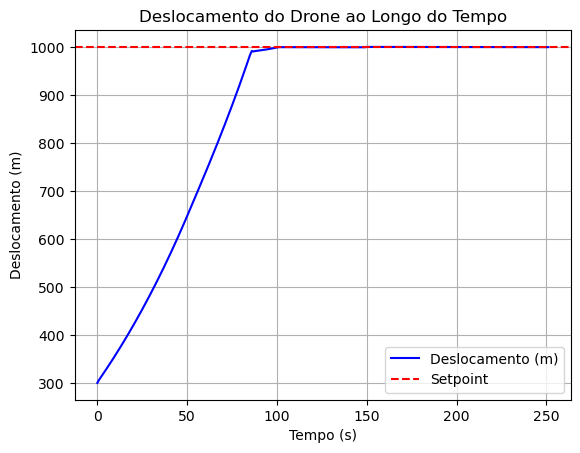

In [14]:
setpoint = 1000
current_position = 300
time = 250
dt = 1
U_max = 4

ErrorControl = ctrl.ControlSystemSimulation(ctrl.ControlSystem(BaseRegras))

positions = [current_position]
errors = [abs(setpoint - current_position)]

for t in range (time + 1):
    
    if current_position < setpoint:
        U_max = 6
    else:
        U_max = 4
    
    current_error = abs(setpoint - current_position)
    errors.append(current_error)
    
    print("Erro atual: {}".format(current_error))
    
    if current_error < 10:
        FA = 0.984825
    elif current_error < 25:
        FA = 0.994
    else:
        FA = 0.996
    
    current_delta_error = (errors[-1] - errors[-2]) / dt
    # print("Delta erro: {}".format(current_delta_error))
    
    ErrorControl.input['erro'] = current_error
    ErrorControl.input['delta_erro'] = current_delta_error
    ErrorControl.compute()
    
    P_Motor = ErrorControl.output['potencia_motor']
    # print("Potencia:   {}".format(P_Motor))
    
    if current_error > 5:
        P_H13 = P_Motor
        P_H24 = P_Motor
    else:
        P_H13 = 0.353
        P_H24 = 0.353
        
    # print("PH13:       {}".format(P_H13))
    # print("PH24:       {}".format(P_H24))
    
    d_t = FA * current_position * 1.01398 + 0.5 * (U_max * P_H13 + U_max * P_H24)
    
    print("Current:    {}".format(current_position))
    
    if current_position < setpoint:
        current_position = d_t
    else:
        delta_movement = d_t - current_position
        current_position = current_position - delta_movement
    
    print("Desloc:     {}".format(d_t))
    # print("Deltamv:    {}".format(delta_movement))
    print("Positio:    {}".format(current_position))
    print("----------------------")
    
    positions.append(current_position)

# Gráfico do deslocamento
plt.plot(range(len(positions)), positions, label='Deslocamento (m)', color='blue')
plt.axhline(setpoint, color='red', linestyle='--', label='Setpoint')
plt.xlabel('Tempo (s)')
plt.ylabel('Deslocamento (m)')
plt.title('Deslocamento do Drone ao Longo do Tempo')
plt.grid()
plt.legend()
plt.show()

# Considerações com Base no Enunciado
1.  Variação Máxima de Saída no Modo S-mode: O enunciado especifica uma velocidade máxima de descida (Umáx) de 4 m/s no S-mode. Essa velocidade máxima limita o quanto o drone pode descer por ciclo de tempo, o que representa o teto para a saída da potência.

2. Erro e Delta de Erro: Vamos definir o erro como uma variável que pode ser apenas positiva, representando a diferença entre a altura atual do drone e o ponto de referência (setPoint). Isso permite que o controle ajuste a velocidade de descida sempre em direção ao ponto alvo.

3. Controle Direto e Reverso em Pares de Motores: Os motores operam em pares e são ajustados por duas bases de regras, uma para o controle direto e outra para o controle reverso, que alternam a intensidade do ajuste para minimizar o erro.

# Construindo a Função de Transferência
Com essas definições, a função de transferência será usada para calcular a potência dos motores de forma proporcional ao erro e ao delta de erro, considerando a variação máxima de saída permitida no modo S-mode (4 m/s), adaptamos a função de transferência para ajustar a saída do controle fuzzy, sem precisar calcular um deslocamento acumulativo. Em vez disso, limitamos a resposta do controle à velocidade máxima permitida.